<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/categories_As_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment to show usefulness of Categorical Embeddings

In [ ]:
# Last amendment: 1st November, 2021
# My folder: /home/ashok/Documents/keras Functional Models-Advanced
# VM: lubuntu_deeplearning_II.7z
# Ref: https://towardsdatascience.com/deep-embeddings-for-categorical-variables-cat2vec-b05c8ab63ac0
#      Data: https://www.kaggle.com/contactprad/bike-share-daily-data

## Summary of techniques  [Transforming Categorical Data](https://developers.google.com/machine-learning/data-prep/transform/transform-categorical)  

OHE, Hashing and Embeddings

### OHE

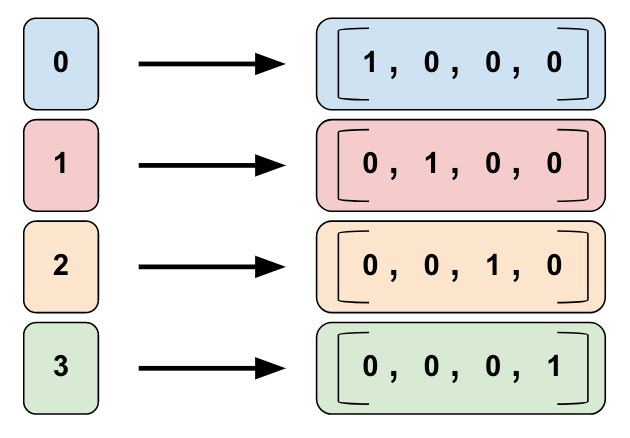

### Conversion of Categories to dense matrix

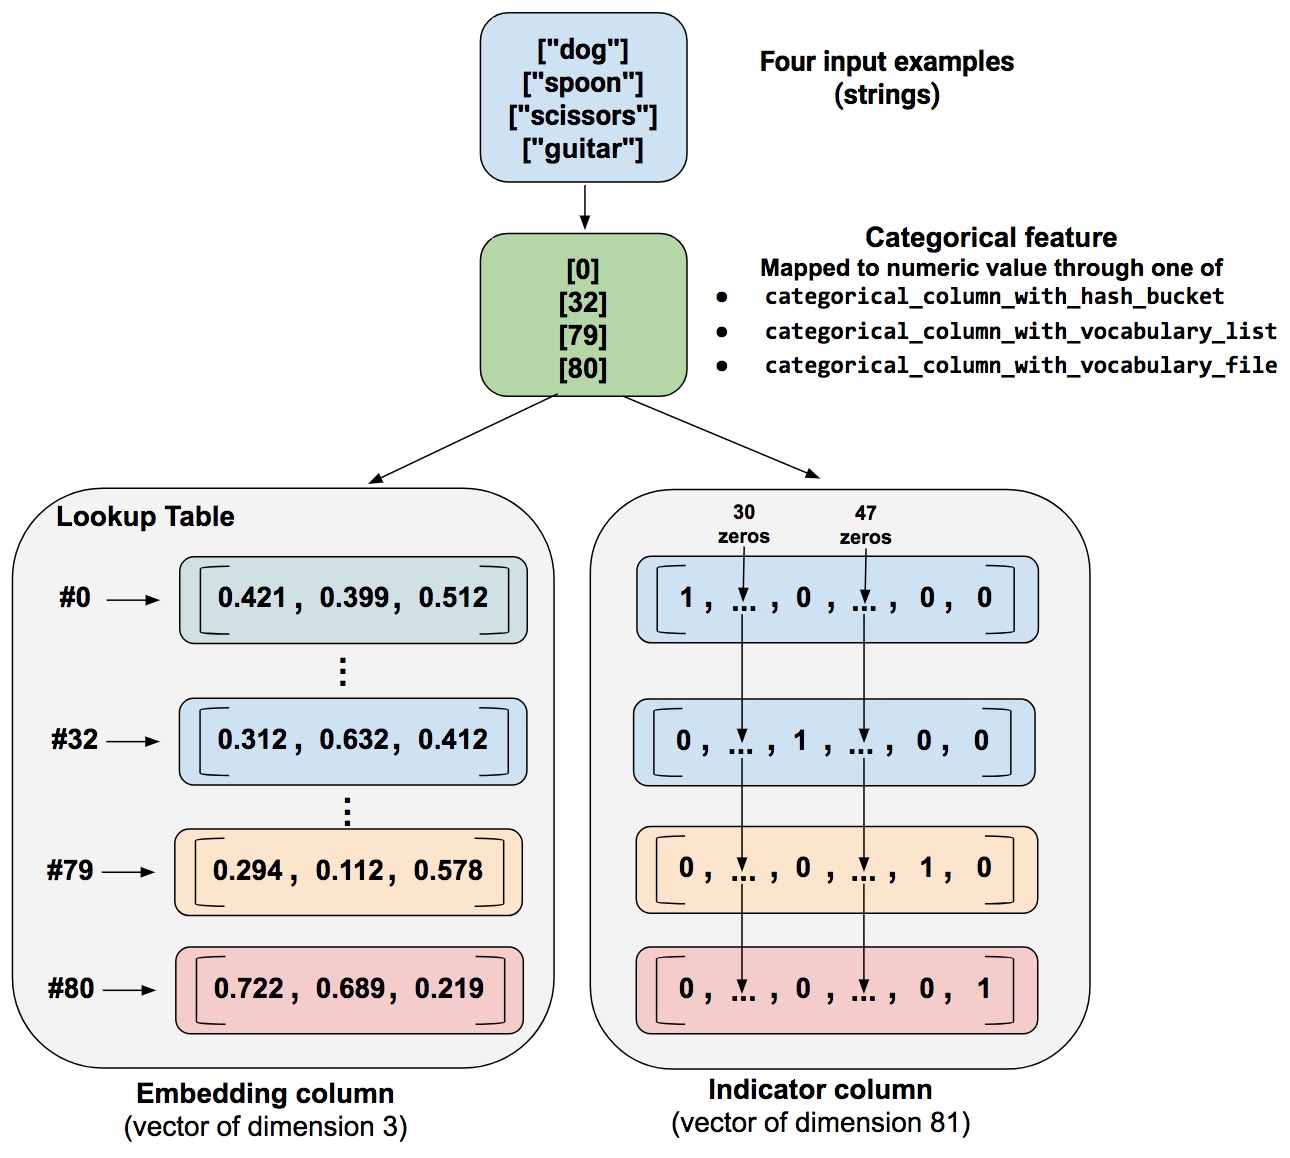

### Categorical embedding may display relationships

image.png

### How categorical embeddings are used

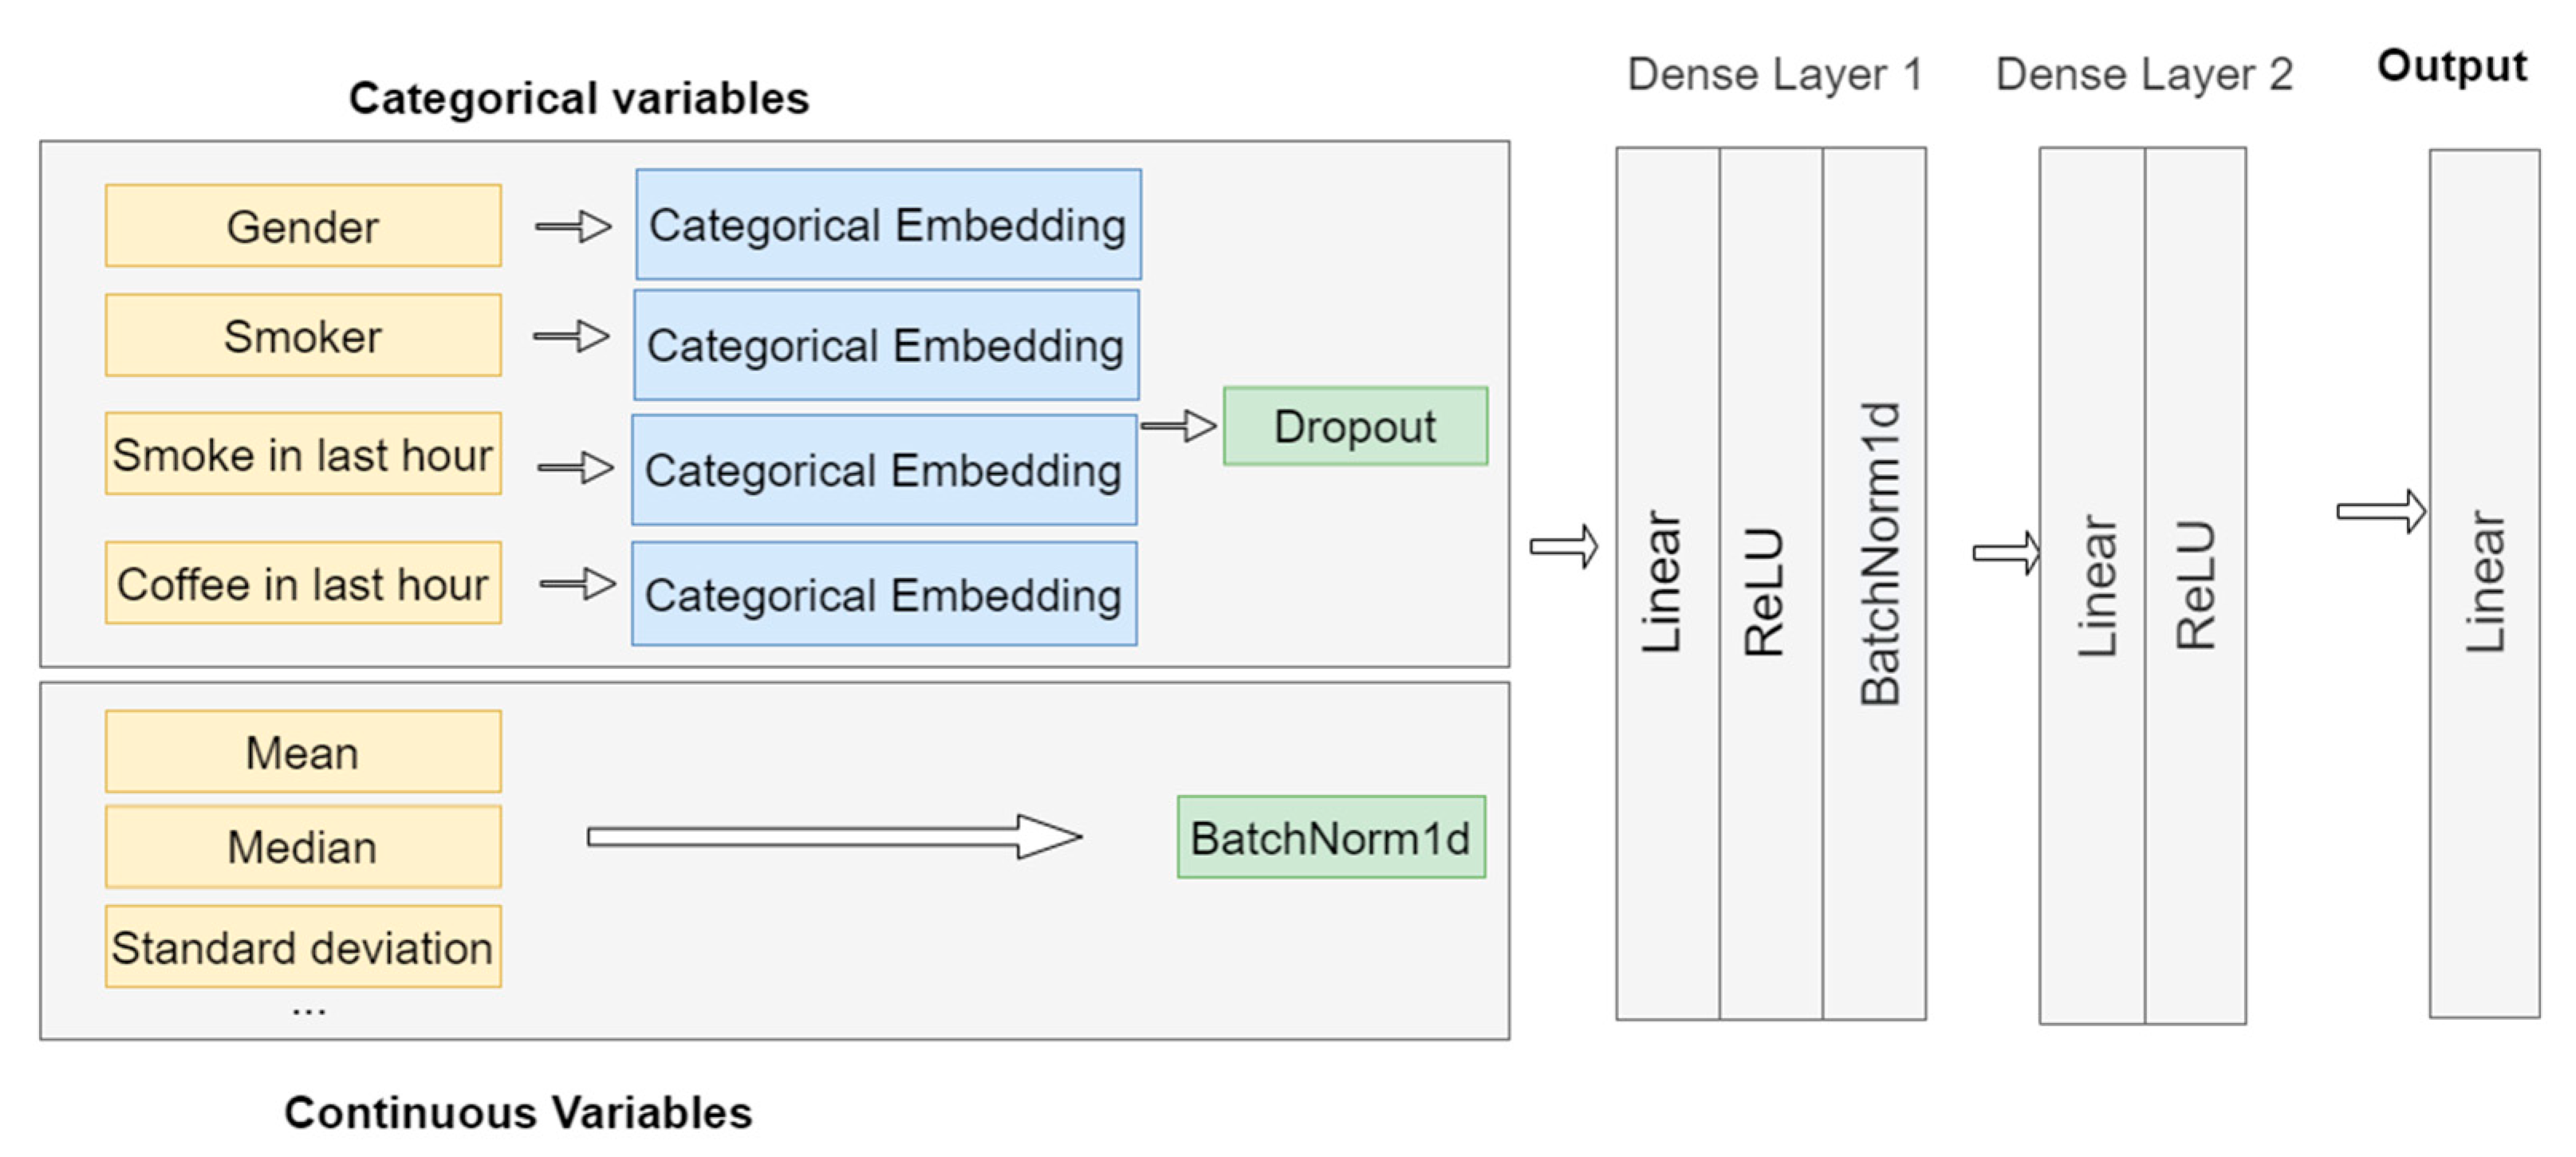

## Call libraries

In [ ]:
# 1.0 Call libraries
import numpy as np
import pandas as pd
# 1.1 Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout
# 1.2 sklearn for scaling data
from sklearn.preprocessing import MinMaxScaler
# 1.3 For plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 
# 1.4 Misc
import os

In [ ]:
# 1.0.1
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# 1.0.2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Read Data

In [ ]:
# 2.0 Read and show Kaggle's bikesharing data
#os.chdir("/home/ashok/.keras/datasets/bikesharing")
os.chdir("/gdrive/MyDrive/Colab_data_files/bikesharing/")
data_df = pd.read_csv('bike_sharing_daily.csv.zip', encoding='latin')
data_df.head()

In [ ]:
# 2.1 Data types
data_df.dtypes

## Display impt data features

In [ ]:
# 2.2 Simple 'groupby()'' example. Only numeric columns will be summed up
df = pd.DataFrame(
                   { 'a': [1,2,3,4],
                     'b' : ['a', 'a', 'b','b'],
                     'c' : ['aa','bb','cc','cc'],
                     'd' : [10,11,12,13]
                   }
                 )

df
# Use groupby to aggregate
#  Only numeric columns are aggregated
df.groupby('b').sum()

In [ ]:
# 3. To simplify matters, We will concern ourselves to just two columns
#    Extract from our data, only two columns
data_small_df = data_df[['cnt','mnth']]
data_small_df.head() 
data_small_df.tail() 


In [ ]:
# 3.1 Order this dataset by mnth (maybe it is already ordered. Just make doubly sure)
data_small_df = data_small_df.sort_values(by=['mnth'])
data_small_df.head()
data_small_df.tail()

In [ ]:
# 3.2 groupby with 'as_index = True'. 'mnth' comes as an index. This is default.
data_plot = data_small_df.groupby('mnth', as_index = True).agg('sum')
data_plot

In [ ]:
# 3.3 groupby with 'as_index = False'. This time 'mnth' is a column
data_plot = data_small_df.groupby('mnth', as_index = False).sum()
data_plot

In [ ]:
# 3.4 Plot the 'cnt' column of this dataset
#     Certain months have same behaviour
data_plot['cnt'].plot.bar(figsize=(10,5))

In [ ]:
# 3.5 Scale the 'cnt' column:

scaler = MinMaxScaler()
data_small_df['cnt_Scaled'] = scaler.fit_transform(data_small_df[['cnt']])
data_small_df.head()

# Traditional Embeddings
One Hot Encodings

In [ ]:
# 4.0 Transform 'mnth' column to dummy variable using pandas get_dummies()

pd.get_dummies(data_small_df['mnth']).head()

# Deep Embedding
Discovering relationships

In [ ]:
# 4.1 Number of unique months:

data_small_df['mnth'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
# 4.2 Just little transformation:

data_small_df['mnth'] = data_small_df['mnth']-1
data_small_df['mnth'] = data_small_df['mnth'].astype(int)

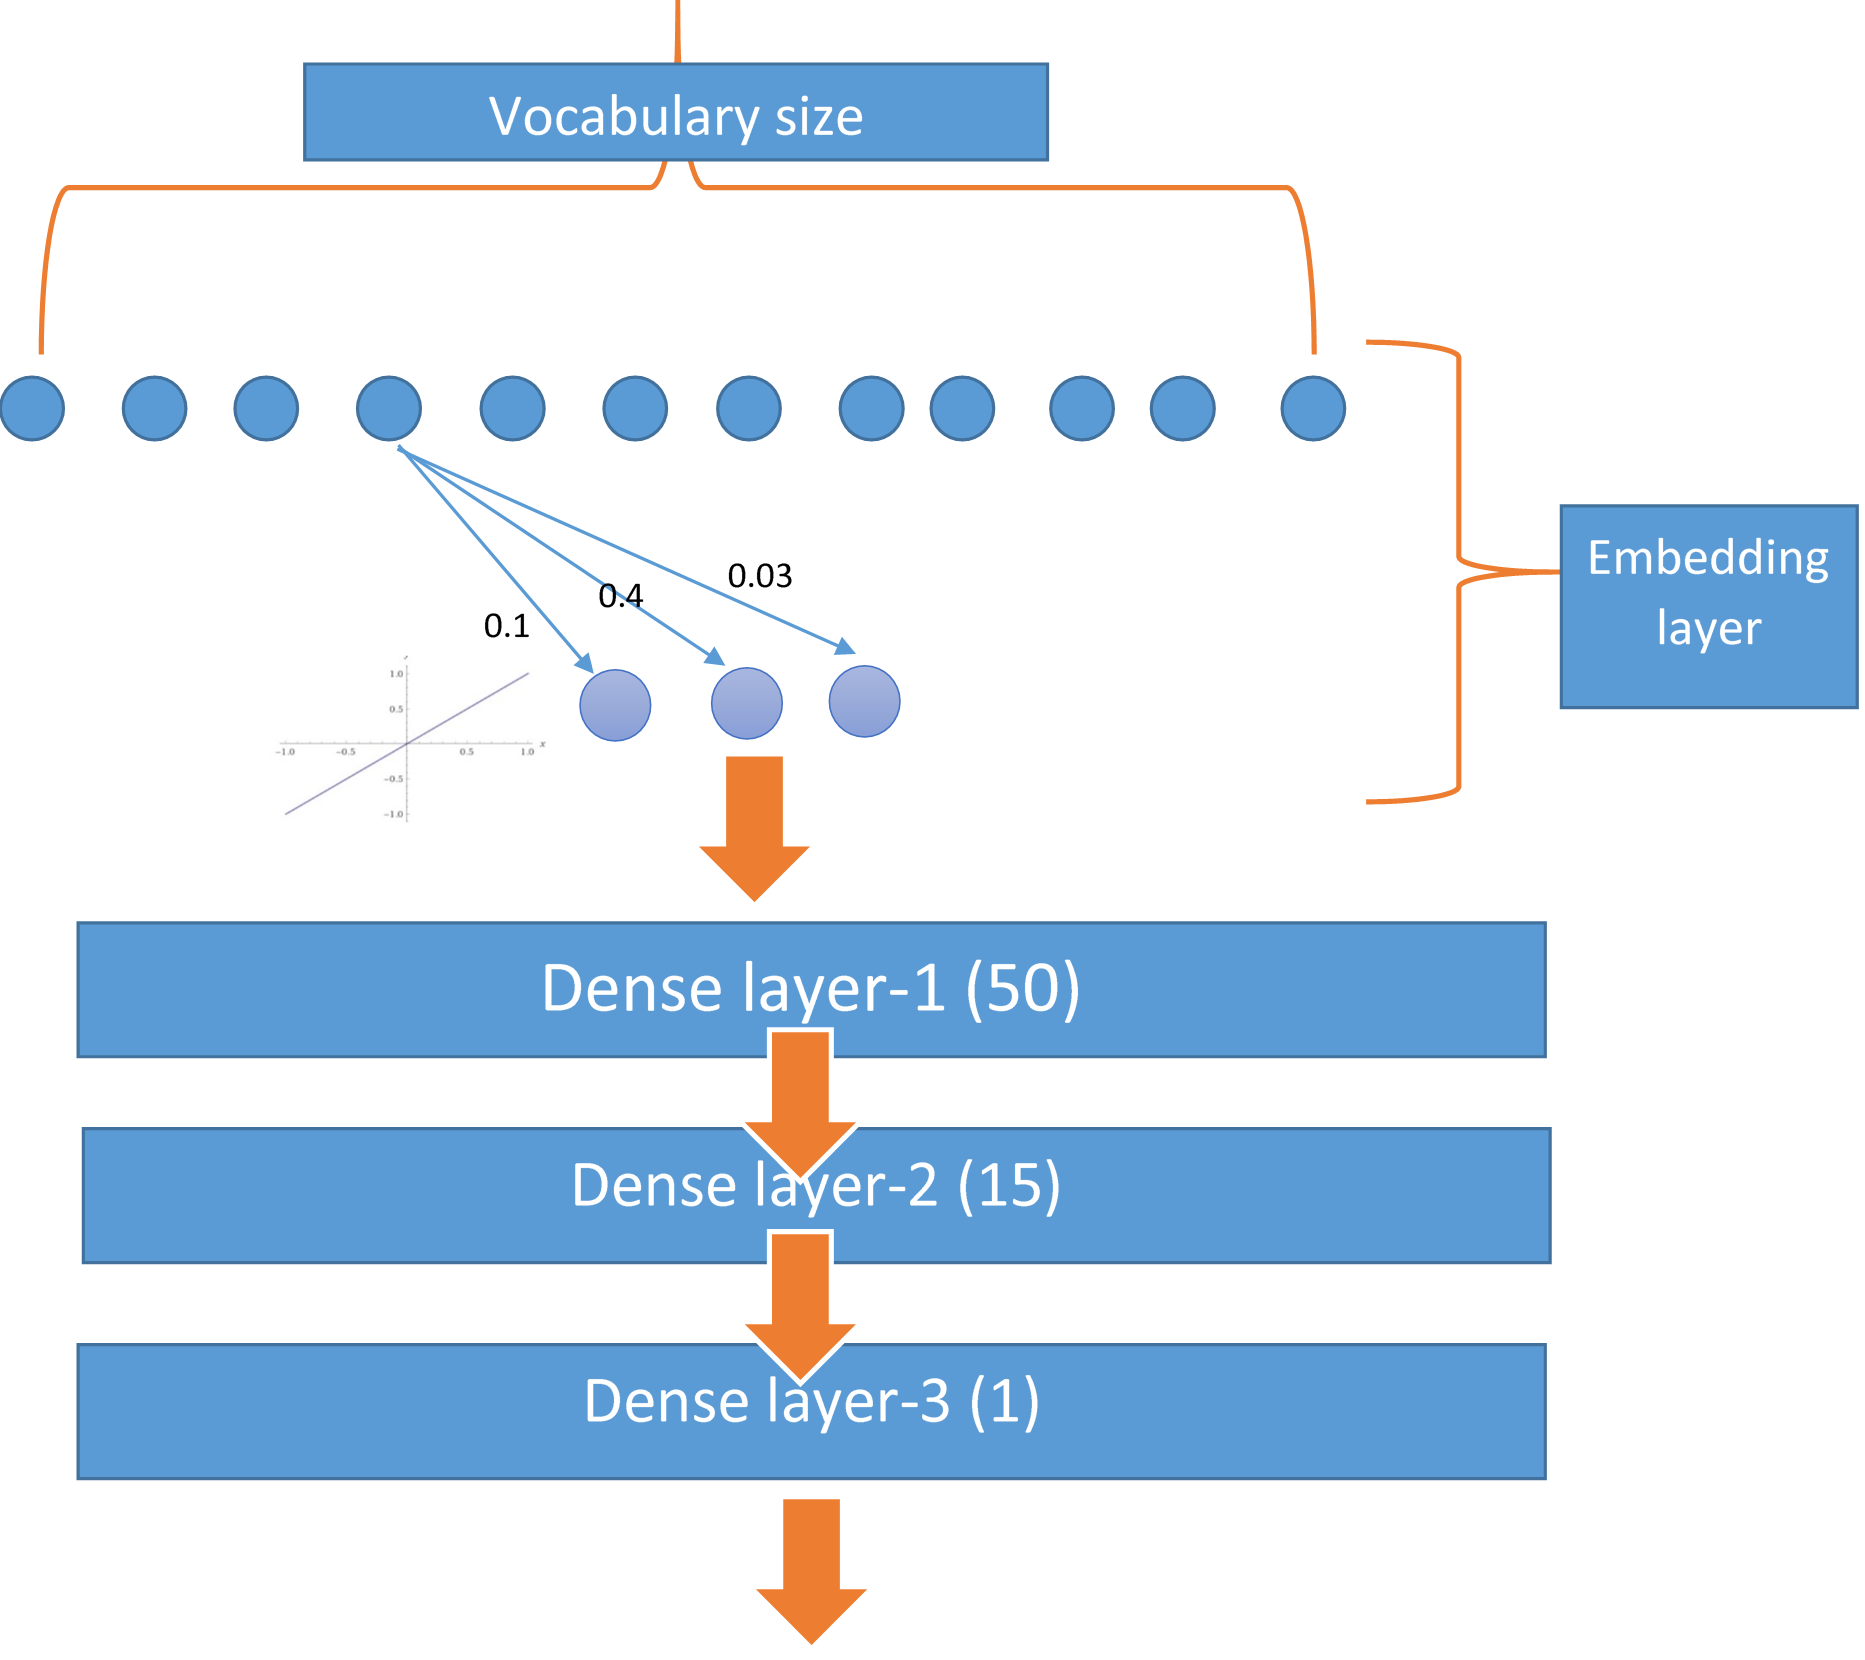

In [ ]:
# 5.0 Getting embeddings for months now.
#     We use a simple NN:

embedding_size = 3
# 5.1 Our sequence input_length in each cell (per row) is just 1.
#     So  input_length = 1
model = Sequential()
model.add(Embedding(input_dim = 12,               # Vocabulary size of 12
                    output_dim = embedding_size,  # Vector size of 3
                    input_length = 1,             # A category, such as: ['sharp knife' ] 
                                                  # would have input_length of 2. But, 
                                                  # a category such as: ['knife'] would have
                                                  #  input_length of 1.
                    name="embedding"              # Layer name. We will later access it by this name
                   )
         )
model.add(Flatten())                        # Needs flattening as output is (embedding_size,1)
model.add(Dense(50, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1))

In [ ]:
# 5.1.1
model.compile(loss = "mse",
              optimizer = "adam",
              metrics=["accuracy"]
              )


# 5.1.2
model.fit(x = data_small_df['mnth'].values,
          y=  data_small_df['cnt_Scaled'].values,
          epochs = 50,
          batch_size = 4
         )

In [ ]:
# 5.2 Model summary
model.summary()

In [ ]:
# 6.0 Get embeddings layer weights
# 6.0.1 First get the 'layer' object
layer = model.get_layer('embedding')


# 6.0.2 Then get this layer's attributes
output_embeddings = layer.get_weights()

In [ ]:
# 6.0.3
type(output_embeddings)     # It is a list that contains one array
print("\n=====")
print(len(output_embeddings))  # 1

In [ ]:
# 6.1
output_embeddings[0]     # Our weights array
print("\n============")
output_embeddings[0].shape  # (12,3)

In [ ]:
# 6.2 Transform array to dataframe
output_embeddings_df = pd.DataFrame(output_embeddings[0])
output_embeddings_df

In [ ]:
# 6.3 Existing index becomes a column and a new index is added
output_embeddings_df.reset_index()

In [ ]:
# 6.4 reset_index() and update data frame
output_embeddings_df = output_embeddings_df.reset_index()
output_embeddings_df.shape   # (12,4)

(12, 4)

In [ ]:
# 6.5 Name columns
output_embeddings_df.columns = ['mnth', 'embedding_1', 'embedding_2', 'embedding_3']
output_embeddings_df

# Vizualisation
Visualization of relationships

In [ ]:
# 6.6 Get three embeddings columns
output_embeddings_df.iloc[:,1:]

In [ ]:
# 7.0 Plot each vector on 3D axis
m = output_embeddings_df.iloc[:,1:].values
labels = output_embeddings_df.iloc[:,0:1].values
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(labels)):
    ax.scatter(m[i,0],m[i,1],m[i,2], color='b')
    ax.text(m[i,0],m[i,1],m[i,2],'%s'%(str(labels[i][0])), size=20, zorder=1, color='k')

ax.set_xlabel('Embedding 1')  
ax.set_ylabel('Embedding 2')  
ax.set_zlabel('Embedding 3')  
plt.show()

In [ ]:
data_plot['cnt'].plot.bar(figsize=(10,5))

In [ ]:
########### I am Done ###############